In [1]:
from IPython.core.interactiveshell import InteractiveShell
from datetime import datetime

#basic externals
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import swifter
import feather
from random import randint
from scipy import stats
import io

#visual libs
import matplotlib.pyplot  as plt
import seaborn as sns
import cv2

# sklearn model imports
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.externals import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_curve, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#local imports
from xm_functions import *

InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_rows = 20
pd.options.display.max_columns = 50 
pd.set_option(
    "display.float_format", lambda x: "%.3f" % x
    )  # display numbers as decimals instead of scientific value

plt.rcParams["font.size"] = (18)

In [2]:
df = pd.read_feather('df_transformed1.feather')
df.shape
df.head(1)

C:\Users\Maly-Fenix\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


(20580, 15)

,id,image,annotation,breed,breed_label,pose,width,height,box_xmin,box_ymin,box_xmax,box_ymax,scene_img,crop_img,masked_img
0,n02085620_10074,Images/n02085620-Chihuahua/n02085620_10074.jpg,Annotation/n02085620-Chihuahua/n02085620_10074,1,Chihuahua,Unspecified,333,500,25,10,276,498,Scene/Chihuahua/n02085620_10074.png,Cropped/Chihuahua/n02085620_10074.jpg,Masked/Chihuahua/n02085620_10074.png


### Trying out SIFT

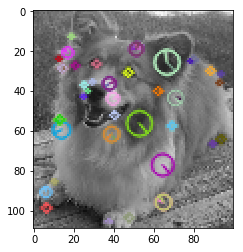

50 descriptors found


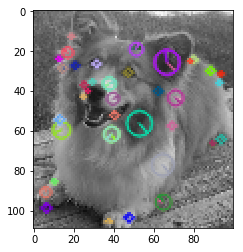

50 descriptors found


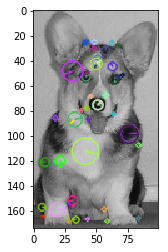

50 descriptors found


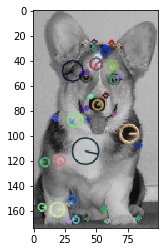

50 descriptors found


In [3]:
sift = cv2.xfeatures2d.SIFT_create(
    nOctaveLayers = 3,
    edgeThreshold = 10,
    sigma = 1.6
)
def sift_descriptors(x, display =False, resize = 100, max_features = 50, flatten=False):
    img = cv2.imread(x['crop_img'], cv2.IMREAD_UNCHANGED) #IMREAD_UNCHANGED to keep 4th channel with transparency
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #img = less_colors(img)
    
    img_width =gray.shape[1]
    if img_width> resize:
        resize_ratio = resize/img_width
        gray = cv2.resize(gray,None,fx=resize_ratio, fy=resize_ratio)
        
    
    kp = sift.detect(gray,None)
    kp = sorted(kp, key=lambda x: -x.response)[:max_features]
    kp, descr = sift.compute(gray,kp)
    if display:
        img=cv2.drawKeypoints(gray,kp, gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        imshow(img)
        print(descr.shape[0], 'descriptors found')
        
    if flatten: # does not work as expected
        descr= descr.flatten()
        needed_size = (max_features * 64)
        if descr.size < needed_size:
            descr = np.concatenate([descr, np.zeros(needed_size - descr.size)])
    return descr.astype(int)

df_sample=df[df.id=='n02113023_12248']
silent = df_sample.apply(lambda x: sift_descriptors(x, display =True),axis=1)
df_sample=df[df.id=='n02113023_2992']
silent = df_sample.apply(lambda x: sift_descriptors(x, display =True),axis=1)


## Visual FLANN Based matches with SIFT and SURF

Fast Library for Approximate Nearest Neighbors

SIFT


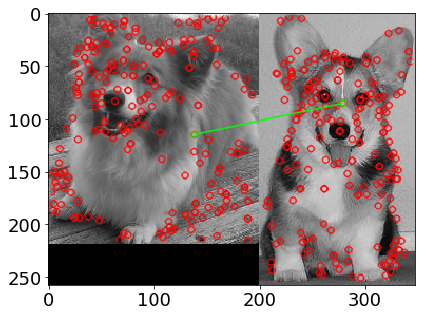

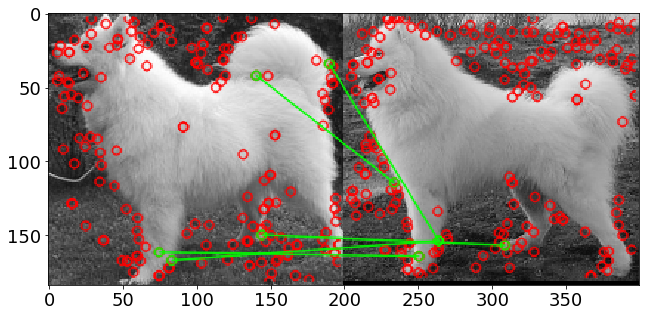

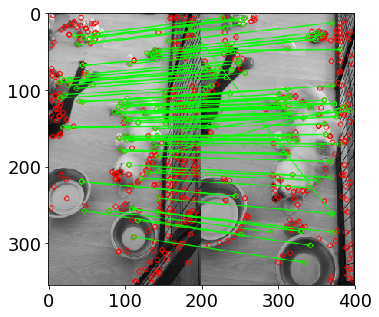

SURF


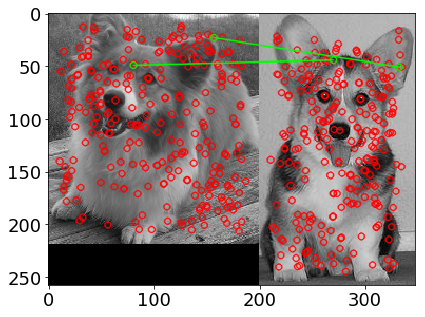

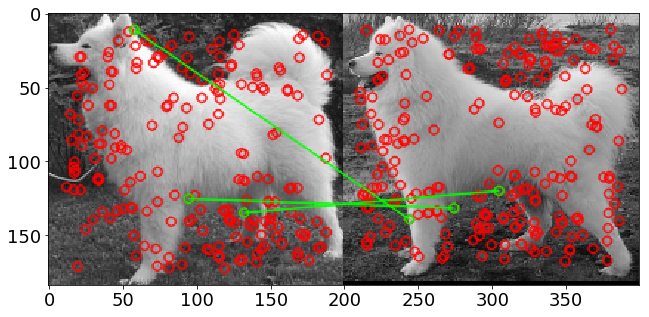

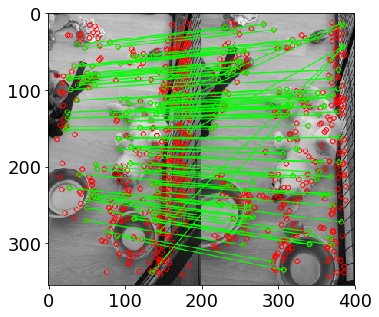

In [4]:
sift = cv2.xfeatures2d.SIFT_create(
    nOctaveLayers = 3,
    edgeThreshold = 10,
    sigma = 1.6)
surf = cv2.xfeatures2d.SURF_create(
    hessianThreshold = 100,
    nOctaves = 4,
    nOctaveLayers = 3
)

def resize_img(img, max_width):
    img_width =img.shape[1]
    if img_width> max_width:
        resize_ratio = max_width/img_width
        img = cv2.resize(img,None,fx=resize_ratio, fy=resize_ratio)
    return img

def FLANN_match(x1, x2, detection=sift, max_width = 200):
    img1 = cv2.imread(x1['crop_img'].values[0],0) # queryImage
    img2 = cv2.imread(x2['crop_img'].values[0],0) # trainImage

    img1 = resize_img(img1, max_width)
    img2 = resize_img(img2, max_width)
        
    fig_size(4,4)

    # find the keypoints and descriptors with SIFT
    kp1, des1 = detection.detectAndCompute(img1,None)
    kp2, des2 = detection.detectAndCompute(img2,None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees =10)
    search_params = dict(checks=200)   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]

    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            matchesMask[i]=[1,0]

    draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       matchesMask = matchesMask,
                       flags = 0)

    img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
    fig_size(15,5)
    plt.imshow(img3,),plt.show()

print('SIFT')
df_sample=df[df.id=='n02113023_12248']
df_sample2=df[df.id=='n02113023_2992']
silent = FLANN_match(df_sample,df_sample2)

df_sample=df[df.id=='n02111889_16676']
df_sample2=df[df.id=='n02111889_1363']
silent = FLANN_match(df_sample,df_sample2)

df_sample=pd.DataFrame(['Ossia/dodo1.jpg'],columns = ['crop_img'] ) 
df_sample2=pd.DataFrame(['Ossia/dodo2.jpg'],columns = ['crop_img'] ) 
silent = FLANN_match(df_sample,df_sample2) 

print('SURF')
df_sample=df[df.id=='n02113023_12248']
df_sample2=df[df.id=='n02113023_2992']
silent = FLANN_match(df_sample,df_sample2, surf)

df_sample=df[df.id=='n02111889_16676']
df_sample2=df[df.id=='n02111889_1363']
silent = FLANN_match(df_sample,df_sample2, surf)

df_sample=pd.DataFrame(['Ossia/dodo1.jpg'],columns = ['crop_img'] ) 
df_sample2=pd.DataFrame(['Ossia/dodo2.jpg'],columns = ['crop_img'] ) 
silent = FLANN_match(df_sample,df_sample2, surf)


## Testing SIFT classification on a reduced set

In [5]:
reduced_set = ['Newfoundland',  'Pembroke', 'Samoyed']
mask = df['breed_label'].isin(reduced_set)
df_reduced = df.loc[mask]
df_reduced.shape

(594, 15)

#### Get max 50 sift descriptors (128 dim) per image

In [6]:
df_results=df_reduced[['crop_img']].swifter.apply(lambda x: sift_descriptors(x),axis=1)

Pandas Apply: 100%|█████████████████████████████████████████████████████████████████| 594/594 [00:03<00:00, 171.23it/s]


In [7]:
df_descr = pd.DataFrame(columns=['id', 'breed']+list(range(128)))
for i in range(df_reduced.shape[0]):
    descr =df_reduced[['crop_img']].iloc[[i]].apply(lambda x: sift_descriptors(x),axis=1).values
    dog_descr =  pd.DataFrame([item for sublist in descr for item in sublist])
    dog_descr['id'] = df_reduced['id'].iloc[i]
    dog_descr['breed'] = df_reduced['breed_label'].iloc[i]
    df_descr = df_descr.append(dog_descr, sort=False)

df_descr.shape
df_descr.sample(5)

(28160, 130)

,id,breed,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,...,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
35,n02111277_1177,Newfoundland,3,5,10,8,1,5,27,12,34,4,9,8,0,5,18,35,132,1,0,0,0,0,8,...,92,7,0,1,1,11,53,106,132,26,45,6,1,82,131,60,22,59,63,3,0,4,6,12,34
41,n02113023_2971,Pembroke,0,2,60,11,3,1,4,0,2,4,31,42,44,1,1,0,16,26,17,13,9,0,2,...,133,133,19,1,0,1,2,1,102,22,33,10,1,9,31,32,11,6,6,9,18,18,18,51,17
48,n02113023_724,Pembroke,1,0,1,10,56,58,8,6,6,2,1,8,70,119,61,39,119,19,1,0,0,5,32,...,28,5,0,0,0,119,119,40,6,105,7,0,0,17,10,0,8,119,18,3,4,0,0,0,1
24,n02111277_3713,Newfoundland,97,3,0,0,0,0,0,8,193,34,0,0,0,0,0,12,60,30,10,5,1,0,1,...,1,193,144,0,0,0,0,0,0,117,71,6,0,0,1,3,5,1,3,3,0,0,1,2,1
16,n02113023_5310,Pembroke,50,4,4,3,25,26,4,25,38,78,7,9,48,12,1,5,135,90,1,1,1,1,0,...,2,135,88,0,0,3,33,14,9,90,51,2,0,4,52,31,14,16,82,7,0,6,8,0,0


## Adding PCA

(28160, 128)

(28160, 32)

0.802 variance preserved with 32 features


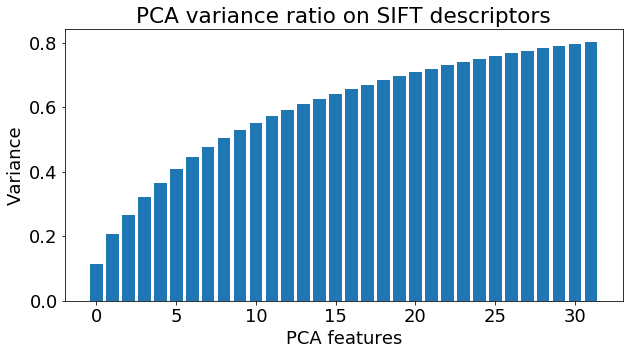

In [8]:
X=df_descr.iloc[:, 2:130]
X.shape

from sklearn.decomposition import PCA
n_components=32
pca = PCA(n_components)
X_pca = pca.fit_transform(X)
X_pca.shape
pca_var_ratios = pca.explained_variance_ratio_

print(round(max(np.cumsum(pca_var_ratios)), 3), 'variance preserved with', n_components,'features')
silent = plt.rcParams["figure.figsize"] = (10,5)
silent = plt.bar(list(range(n_components)), np.cumsum(pca_var_ratios))
legend(plt, 'PCA variance ratio on SIFT descriptors', 'PCA features', 'Variance')


#### Use Kmeans to cluster sift descriptors together

In [9]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters = 40)
clusters = km.fit_predict(X_pca)


In [10]:
len(clusters)
df_kmeans = df_descr[['id', 'breed']].copy()
df_kmeans['cluster'] =clusters
df_kmeans.head(3)

28160

,id,breed,cluster
0,n02111277_1008,Newfoundland,21
1,n02111277_1008,Newfoundland,5
2,n02111277_1008,Newfoundland,25


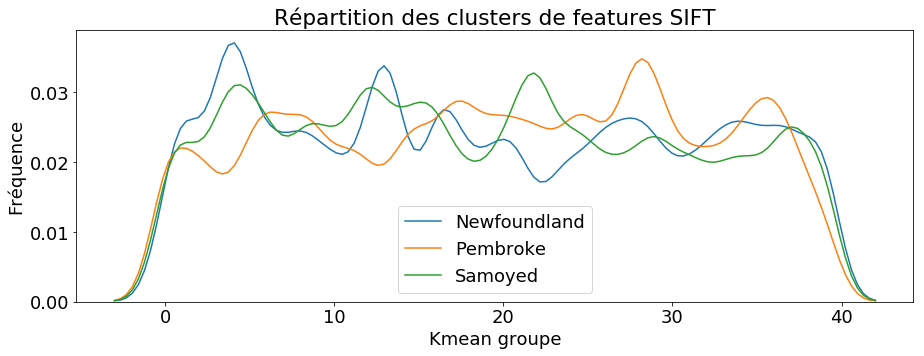

In [20]:
fig_size(15,5)
for breed in reduced_set:
    myplt = sns.kdeplot(df_kmeans['cluster'][df_kmeans.breed==breed].values, label = breed, bw=1)

legend(myplt, 'Répartition des clusters de features SIFT', 'Kmean groupe', 'Fréquence');

## TRain & test split

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
df_agg = df_kmeans.groupby('id').aggregate(lambda x: list(x))
df_agg['breed']= df_kmeans.groupby('id').agg({'breed': 'first'})
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_agg['cluster'].astype(str))
X.shape
X=pd.DataFrame(X.toarray(), index = df_agg.index)

y=df_agg['breed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42, stratify=y )

(594, 30)

## Display distribution as 2D plot

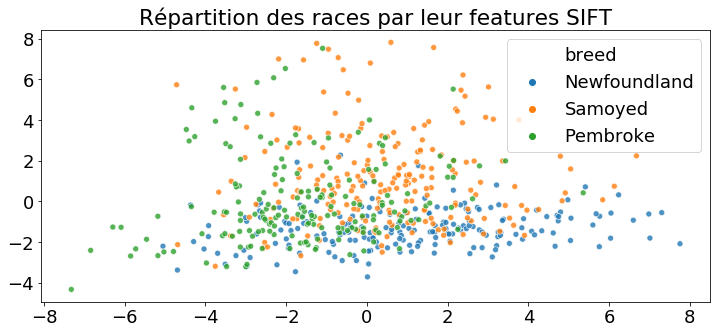

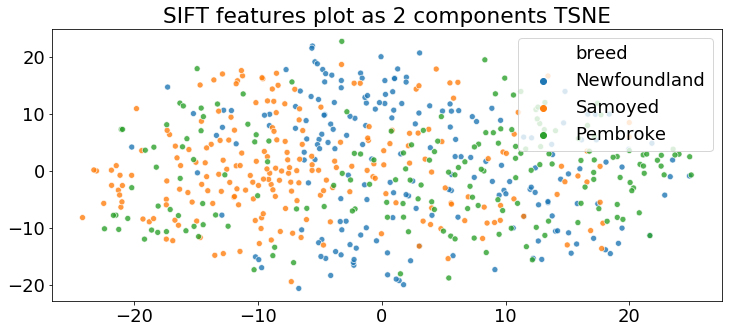

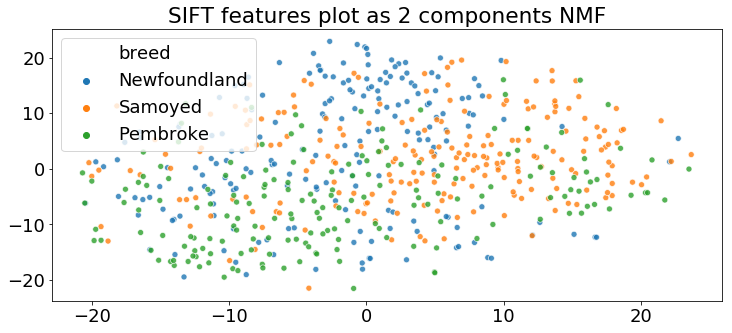

In [24]:
pca =PCA(n_components = 2)
pca_plot = pca.fit_transform(X)
y_ints = pd.factorize(y)[0]
fig_size(12,5)
sns.scatterplot(pca_plot[:,0], pca_plot[:,1], hue=y, alpha=0.8, legend='full')
#legend(plt,'SIFT features plot as 2 components PCA')
legend(plt, 'Répartition des races par leur features SIFT');
plt.show()

from sklearn.manifold import TSNE
model =TSNE(n_components = 2)
model_plot = model.fit_transform(X)
y_ints = pd.factorize(y)[0]
fig_size(12,5)
sns.scatterplot(model_plot[:,0], model_plot[:,1], hue=y, alpha=0.8, legend='full')
legend(plt,'SIFT features plot as 2 components TSNE')
plt.show()

from sklearn.decomposition import NMF 
nmf =NMF(n_components = 2)
model_plot = model.fit_transform(X)
y_ints = pd.factorize(y)[0]
fig_size(12,5)
sns.scatterplot(model_plot[:,0], model_plot[:,1], hue=y, alpha=0.8, legend='full')
legend(plt,'SIFT features plot as 2 components NMF')
plt.show()

# Predictions

In [14]:
from sklearn.svm import LinearSVC
clf = LinearSVC(max_iter = 5000)
silent = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print('Score of :',clf.score(X_test, y_test))
print('Note : Inferior to random forests')

C:\Users\Maly-Fenix\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Score of : 0.6510067114093959
Note : Inferior to random forests


Highest score is 0.6430659080838914 Hyperparam  n_estimators : 37
37
Highest score is 0.6683104888471824 Hyperparam  n_estimators : 33
33


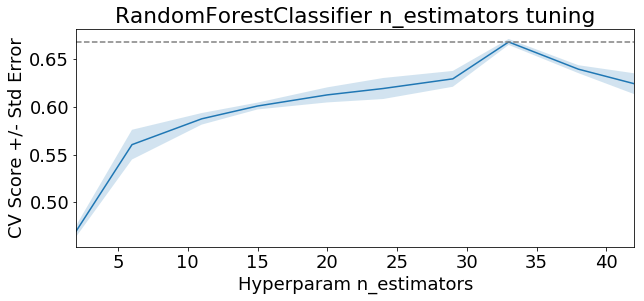

Highest score is 0.6480656542896678 Hyperparam  max_depth : 21
21
Highest score is 0.643040528661527 Hyperparam  max_depth : 10
10


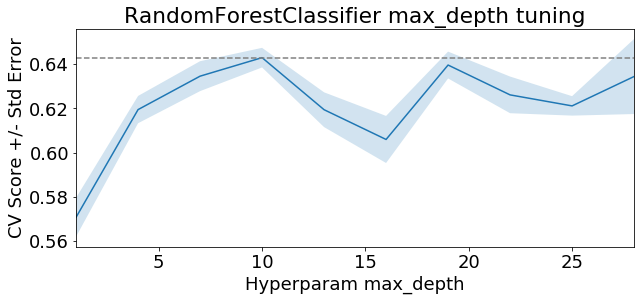

Highest score is 0.6447664152686728 Hyperparam  min_samples_split : 2
2
Highest score is 0.6497149731978699 Hyperparam  min_samples_split : 20
20
Highest score is 0.666609981662401 Hyperparam  min_samples_split : 11
11


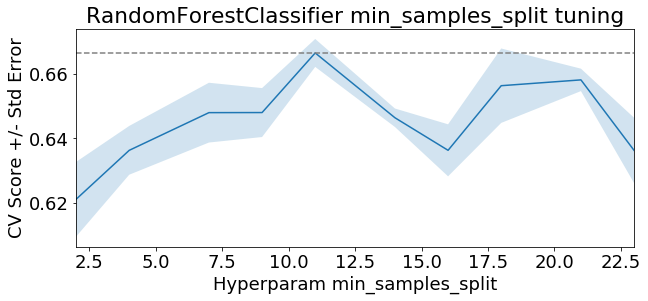

Highest score is 0.6497659897017088 Hyperparam  min_samples_leaf : 14
14
Highest score is 0.6631918759051887 Hyperparam  min_samples_leaf : 4
4


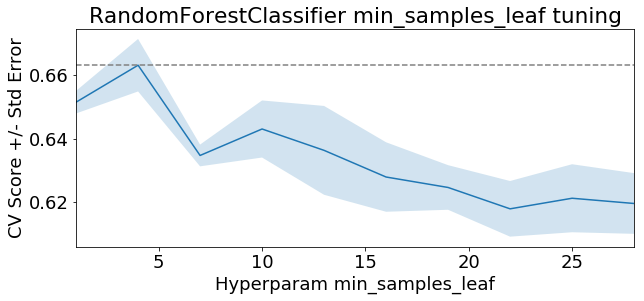

Score of : 0.610738255033557
              precision    recall  f1-score   support

Newfoundland       0.67      0.73      0.70        49
    Pembroke       0.53      0.51      0.52        45
     Samoyed       0.62      0.58      0.60        55

   micro avg       0.61      0.61      0.61       149
   macro avg       0.61      0.61      0.61       149
weighted avg       0.61      0.61      0.61       149



In [15]:
rf = RandomForestClassifier()
rf.n_estimators = hyper_param(rf, X, y, 'n_estimators')
rf.max_depth = hyper_param(rf, X, y, 'max_depth')
rf.min_samples_split = hyper_param(rf, X, y, 'min_samples_split')
rf.min_samples_leaf = hyper_param(rf, X, y, 'min_samples_leaf')


silent = rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print('Score of :',rf.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Confusion matrix, without normalization
[[36  8  5]
 [ 7 23 15]
 [11 12 32]]


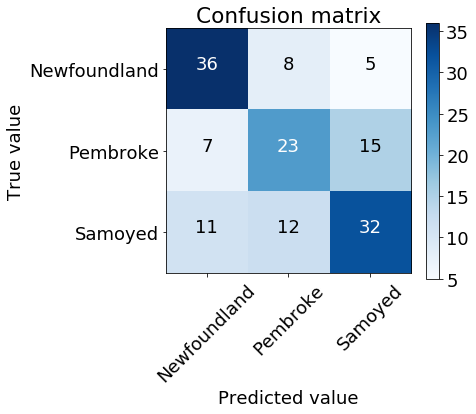

In [25]:
fig_size(7,7)
cm = confusion_matrix(y_test, y_pred, labels =reduced_set)
silent =plot_confusion_matrix(cm, reduced_set)

## Displaying some fails

In [130]:
full_data_df = df
full_data_df.index = full_data_df.id

df_results = pd.DataFrame(np.vstack((y_pred, y_test.values)).T, columns =['predicted', 'true'], index = X_test.index)
labels = df_results['true'].unique()
my_query = '(true == "{0}" and predicted == "{1}") or (true =="{1}" and predicted =="{0}")'.format(labels[0], labels[-1])
df_worst_errors = df_results.query(my_query)
df_worst_errors = df_worst_errors.join(full_data_df).join(X)

Pembroke predicted as Newfoundland


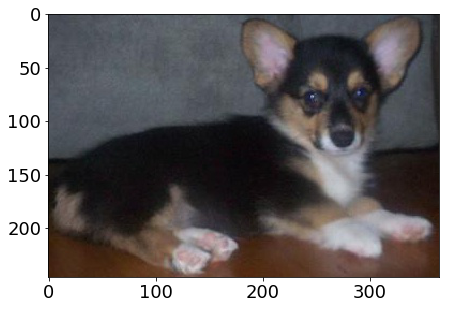

Newfoundland predicted as Pembroke


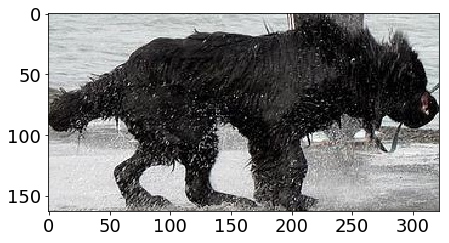

Newfoundland predicted as Pembroke


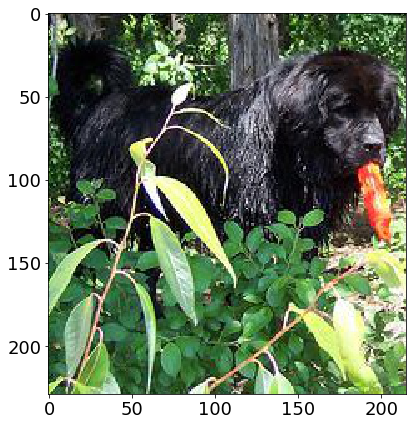

Pembroke predicted as Newfoundland


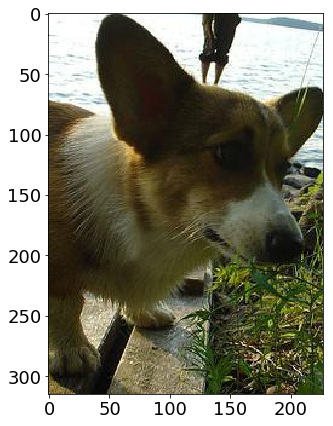

Newfoundland predicted as Pembroke


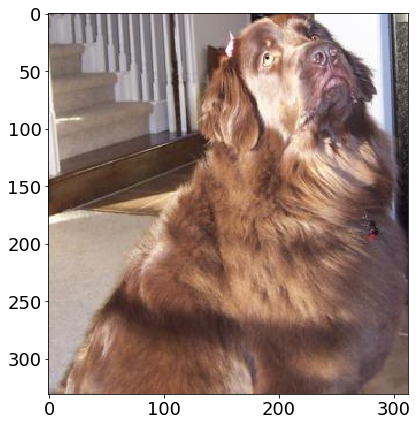

Pembroke predicted as Newfoundland


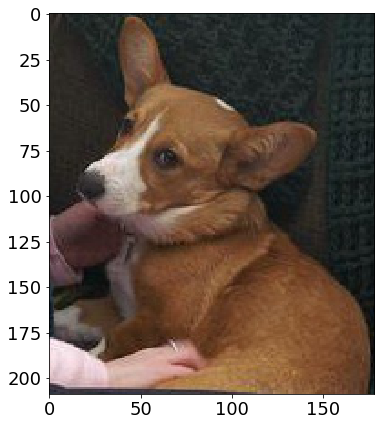

Pembroke predicted as Newfoundland


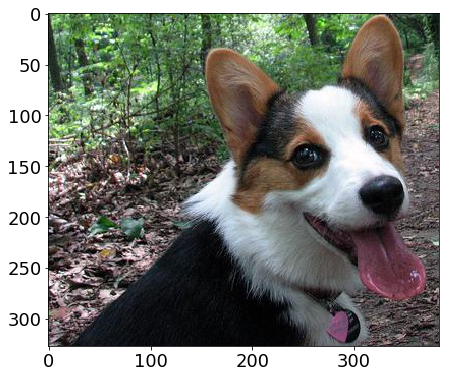

Newfoundland predicted as Pembroke


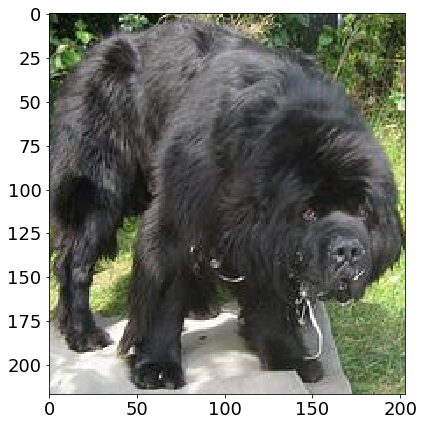

Pembroke predicted as Newfoundland


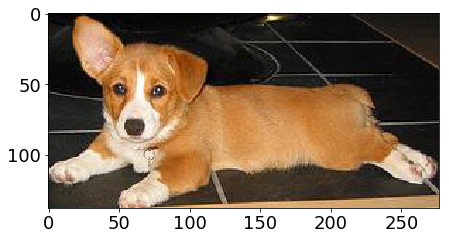

In [131]:
for index, row in df_worst_errors.iterrows() :
    print(row['true'], 'predicted as', row['predicted'])
    img = cv2.imread(row['crop_img'], cv2.IMREAD_UNCHANGED) #IMREAD_UNCHANGED to keep 4th channel with transparency
    imshow(img)
    